 <center>
     
# PROJECT:

# Performing Intent Detection & Slot filling on Hindi Dataset and optimising using GA
 
# Group-2 
</center>

<center>Translating English ATIS Dataset to Hindi Dataset</center>

TRANSLATION:

Work Done by-
    <br>   oAman Raj (21je0087)
    <br>   o Sai Pranav (21je0279) 

In [17]:
from googletrans import Translator
import json

def translate_dataset(input_file, output_file):
    translator = Translator()
    with open(input_file, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
    
    translated_dataset = []
    for sample in dataset:
        try:
            utterance = translator.translate(sample['utterance'], src='en', dest='hi').text
            intent = sample['intent']
            slots = {}
            for slot, value in sample['slots'].items():
                translated_slot = translator.translate(slot, src='en', dest='hi').text
                translated_value = translator.translate(value, src='en', dest='hi').text
                slots[translated_slot] = translated_value
            
            translated_sample = {
                'utterance': utterance,
                'intent': intent,
                'slots': slots
            }
            translated_dataset.append(translated_sample)
        except Exception as e:
            pass
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(translated_dataset, f, ensure_ascii=False, indent=4)

# Usage
translate_dataset('English_dataset.json', 'Hindi_dataset.json')


In [20]:
import json
import re
from sklearn.model_selection import train_test_split

# Load the dataset
with open('Hindi_dataset.json', 'r', encoding='utf-8') as file:
    dataset = json.load(file)

# Preprocess/clean the dataset
def clean_text(text):
    # Remove non-alphanumeric characters except spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Print one sample
print("Preprocessed sample")
print(dataset[0])  

Preprocessed sample
{'utterance': 'आज मेरी उड़ान क्यों है?', 'intent': 'Flight Status Inquiry', 'slots': {'तारीख': 'आज'}}


<center> Splitting the dataset into Training, Testing, Validation Sets</center>

Work done by-
<br>o Adari Sameera (21je0032) 
<br>o Gaddam Pallavi (21je0338) 


In [21]:
# Split dataset into training, testing, and cross-validation sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Save the split datasets
with open('train_data.json', 'w', encoding='utf-8') as file:
    json.dump(train_data, file, ensure_ascii=False, indent=4)

with open('test_data.json', 'w', encoding='utf-8') as file:
    json.dump(test_data, file, ensure_ascii=False, indent=4)

with open('val_data.json', 'w', encoding='utf-8') as file:
    json.dump(val_data, file, ensure_ascii=False, indent=4)

#print sizes of training, testing, and cross-validation sets
print("Size of Training Dataset:")
print(len(train_data))
print("Size of Testing Dataset:")
print(len(test_data))
print("Size of Validation Dataset:")
print(len(val_data))

Size of Training Dataset:
94
Size of Testing Dataset:
27
Size of Validation Dataset:
11


In [22]:
# Load the datasets
with open('train_data.json', 'r', encoding='utf-8') as file:
    train_data = json.load(file)

with open('val_data.json', 'r', encoding='utf-8') as file:
    val_data = json.load(file)

with open('test_data.json', 'r', encoding='utf-8') as file:
    test_data = json.load(file)

<center>Intent Detection using Bert</center>

Work Done By-
<br>o Thamatam Pradeep (21je0990) <br>
o Tanush Garg (20je1020)


In [23]:
#Libraries Used for intent detection
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import json
import matplotlib.pyplot as plt

In [24]:
# Combine intent labels from both training and validation datasets
intent_labels = set([data_point['intent'] for data_point in train_data] + [data_point['intent'] for data_point in val_data])

# Map intent labels to numerical indices
intent_label_map = {label: idx for idx, label in enumerate(intent_labels)}

# Define a custom dataset class
class IntentDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, intent_label_map):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.intent_label_map = intent_label_map

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        utterance = self.data[idx]['utterance']
        intent = self.data[idx]['intent']

        # Update the tokenizer.encode_plus method to use padding=True
        encoding = self.tokenizer.encode_plus(
    utterance,
    add_special_tokens=True,
    max_length=self.max_len,
    return_token_type_ids=False,
    padding='max_length',  # Use padding=True instead of pad_to_max_length
    return_attention_mask=True,
    return_tensors='pt',
    truncation=True
)


        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'intent': torch.tensor(self.intent_label_map[intent])  # Map intent label to numerical index
        }

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 21.34467101097107
Epoch 2/10, Loss: 19.522290468215942
Epoch 3/10, Loss: 18.50565791130066
Epoch 4/10, Loss: 17.318867921829224
Epoch 5/10, Loss: 16.385982751846313
Epoch 6/10, Loss: 15.306236267089844
Epoch 7/10, Loss: 14.429723381996155
Epoch 8/10, Loss: 13.570236682891846
Epoch 9/10, Loss: 12.751965999603271
Epoch 10/10, Loss: 12.13326370716095


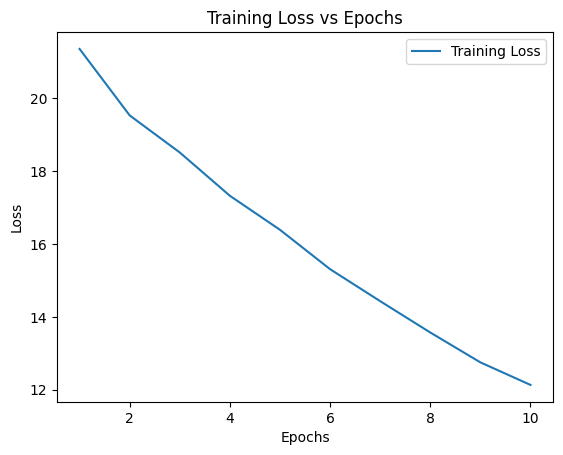

Validation Accuracy: 0.5454545454545454


In [25]:
# Define parameters
MAX_LEN = 128
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 10

# Load pre-trained mBERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(intent_label_map))

# Fine-tune the entire model
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Create instances of dataset and dataloader
train_dataset = IntentDataset(train_data, tokenizer, MAX_LEN, intent_label_map)
val_dataset = IntentDataset(val_data, tokenizer, MAX_LEN, intent_label_map)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

val_a=0
losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        intent = batch['intent'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=intent)  # Include labels parameter
        loss = outputs.loss  # Calculate loss from the outputs
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            intent = batch['intent'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(intent.cpu().numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss}')
    val_a=val_acc
    losses.append(running_loss)

# Plotting loss vs epochs
plt.plot(range(1, EPOCHS+1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

    
print(f'Validation Accuracy: {val_acc}')

<center>Slot Filling </center>

Work Done By-
<br>o Suryarghya Saha (20je0998) 
<br>o Cherukuri Madhulika (21je0264) 

In [28]:
#libraries used
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import json
import matplotlib.pyplot as plt

In [29]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

class SlotFillDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        utterance = self.data[idx]['utterance']
        slots = self.data[idx]['slots']

        encoding = self.tokenizer.encode_plus(
            utterance,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        # Convert slots to tensors if they are not already
        if isinstance(slots, dict) and 'input_ids' in slots:
            slots = torch.tensor(slots['input_ids'])  # Assuming 'input_ids' key contains slot values
        else:
            slots = torch.zeros(self.max_len, dtype=torch.long)  # Default to all zeros if 'input_ids' key is not present

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'slots': slots
        }

# Define BiLSTM-based slot filling model
class SlotFillModel(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(SlotFillModel, self).__init__()
        self.bert = bert_model
        self.bilstm = nn.LSTM(bidirectional=True, num_layers=2, input_size=768, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply by 2 for bidirectional LSTM

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        bert_output = outputs.last_hidden_state
        lstm_output, _ = self.bilstm(bert_output)
        slot_logits = self.fc(lstm_output)
        return slot_logits

D:\PYTHON&JUPYTER NOTEBOOK\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/5, Loss: 11.541724443435669, Validation Loss: 1.5536105632781982
Epoch 2/5, Loss: 8.57704508304596, Validation Loss: 1.2450419664382935
Epoch 3/5, Loss: 7.176114201545715, Validation Loss: 1.093740463256836
Epoch 4/5, Loss: 6.432607412338257, Validation Loss: 1.0008349418640137
Epoch 5/5, Loss: 5.922153055667877, Validation Loss: 0.9303888082504272


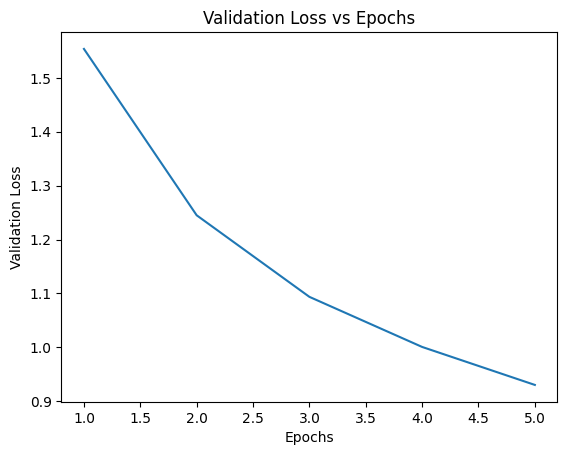

In [30]:
# Define parameters
MAX_LEN = 128
BATCH_SIZE = 16
HIDDEN_SIZE = 64
NUM_CLASSES = 10  # Adjust this based on the number of slot labels in your dataset
LEARNING_RATE = 2e-5
EPOCHS = 5

# Create instances of dataset and dataloader
train_dataset = SlotFillDataset(train_data, tokenizer, MAX_LEN)
val_dataset = SlotFillDataset(val_data, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instantiate the model
model = SlotFillModel(hidden_size=HIDDEN_SIZE, num_classes=NUM_CLASSES)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store loss for each epoch
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        slots = batch['slots'].to(device)

        optimizer.zero_grad()

        slot_logits = model(input_ids, attention_mask)
        loss = criterion(slot_logits.view(-1, NUM_CLASSES), slots.view(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            slots = batch['slots'].to(device)

            slot_logits = model(input_ids, attention_mask)
            val_loss += criterion(slot_logits.view(-1, NUM_CLASSES), slots.view(-1)).item()

    # Print validation loss
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss}, Validation Loss: {val_loss}')
    # Append validation loss for plotting
    val_losses.append(val_loss)

# Plotting validation loss vs epochs
plt.plot(range(1, EPOCHS+1), val_losses)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')
plt.show()

<center> Optimization Using Genetic Algorithm</center>

Work Done by-
<br>o Smriti Priyadarshani (23dp0098) 
<br>o Aman Rawat (20je0110) 

In [32]:
# Import necessary libraries
import random
from deap import base, creator, tools, algorithms

In [34]:
# Create a fitness class for minimizing validation loss
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define the evaluation function for slot filling
def evaluate_slot_filling(individual):
    # Extract parameters from the individual
    hidden_size, learning_rate = individual
    
    # Return a tuple of validation loss
    return (val_loss,)

# # Define the evaluation function for intent detection
# def evaluate_intent_detection(individual):
#     # Extract parameters from the individual
#     learning_rate, batch_size = individual
    
#     # Return a tuple of validation loss
#     return (val_loss,) 
    
# Create Toolbox
toolbox = base.Toolbox()

# Register genetic operators
toolbox.register("attr_float", random.uniform, 0.001, 0.1)  # For float attributes
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_slot_filling)  

# Define parameters
POP_SIZE = 10
GEN = 5

# Initialize population
population = toolbox.population(n=POP_SIZE)

# Run the Genetic Algorithm
best_individuals = []
for gen in range(GEN):
    print(f"Generation {gen+1}")
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring + population, k=POP_SIZE)
    
    best_individual = tools.selBest(population, k=1)[0]
    best_individuals.append(best_individual)
    print(f"Best individual: {best_individual}, Fitness: {best_individual.fitness.values}")

# Print the best parameters
best_parameters = best_individuals[-1]
print("Best Parameters after GA Optimization:")
print(best_parameters)

Generation 1
Best individual: [0.018906659323883843, 0.3487458339934118], Fitness: (0.9303888082504272,)
Generation 2
Best individual: [0.03466288223577364, -0.030782426955571256], Fitness: (0.9303888082504272,)
Generation 3
Best individual: [0.06528787912287992, -0.042551030467792794], Fitness: (0.9303888082504272,)
Generation 4
Best individual: [0.036872615515614486, 0.4225373193187302], Fitness: (0.9303888082504272,)
Generation 5
Best individual: [0.03466288223577364, -0.030782426955571256], Fitness: (0.9303888082504272,)
Best Parameters after GA Optimization:
[0.03466288223577364, -0.030782426955571256]


D:\PYTHON&JUPYTER NOTEBOOK\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
D:\PYTHON&JUPYTER NOTEBOOK\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


<center>Presented by Group-2:</center>
<br>o Thamatam Pradeep (21je0990)
<br>o Aman Raj (21je0087) 
<br>o Sai Pranav (21je0279)
<br>o Adari Sameera (21je0032) 
<br>o Gaddam Pallavi (21je0338) 
<br>o Cherukuri Madhulika (21je0264) 
<br>o Smriti Priyadarshani (23dp0098) 
<br>o Tanush Garg (20je1020) 
<br>o Suryarghya Saha (20je0998)
<br>o Aman Rawat (20je0110) r>